# DSMCER Lecture 5: Splitting and Feature Eng 1

1. Does a random split test my goal?
    1. _Exercise_: Where are the data points for a mixture?
    2. New goal new split
    3. _Poll_: How well will the model perform?
    4. Feature distributions should overlap
2. Feature engineering
    1. _Poll_: can we compute useful information?
    2. Compute features for nominal data
    3. _Exercise_: cross validation

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

***
***

<font size=5><center>In the previous notebook we created an estimator to predict whether a __new sample would be solid before having to make it__.

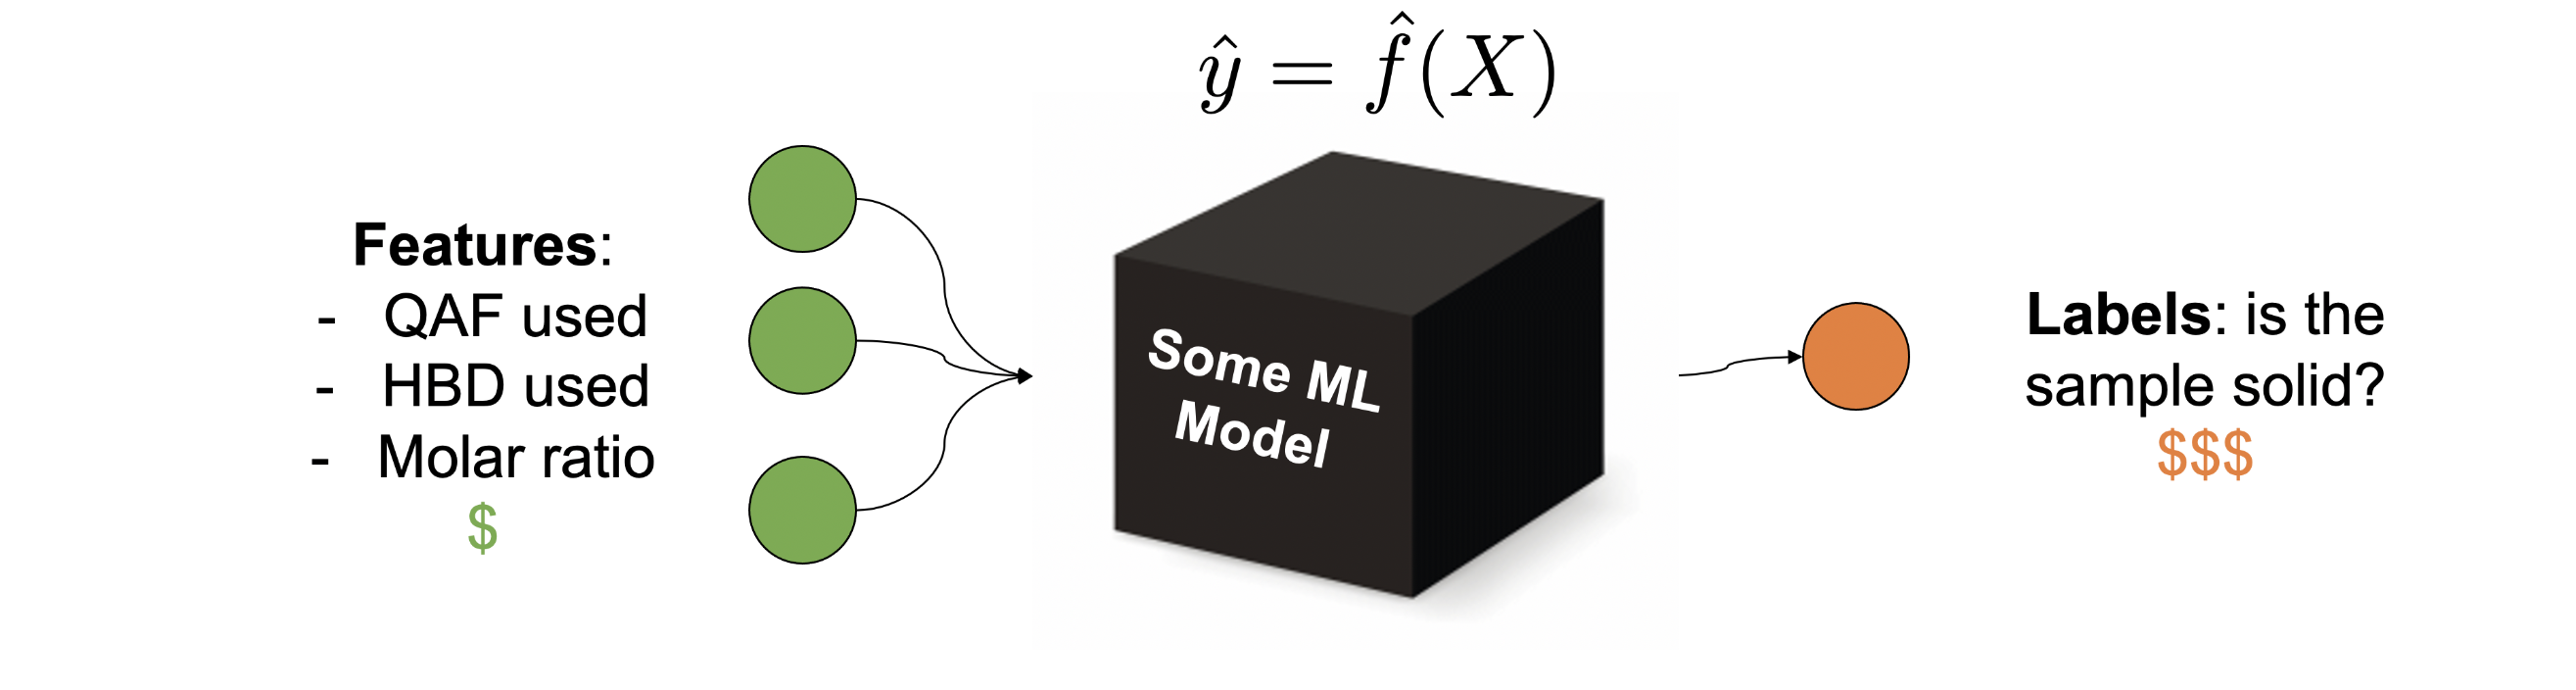

<font size=5><center>We randomly split our dataset in order to __test our primary objective above__.

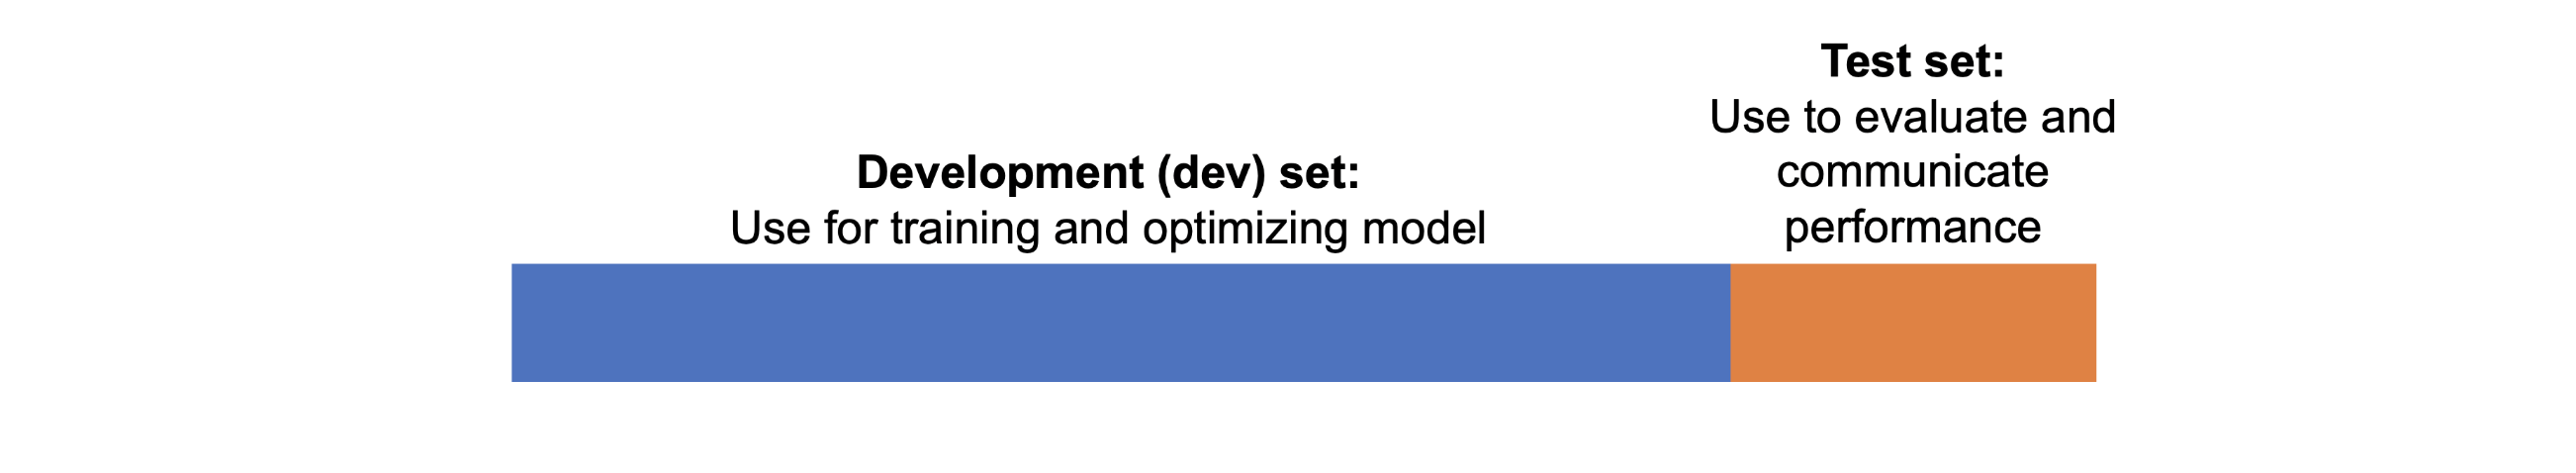

<font size=5><center>We chose a KNN for our architecture and we __encoded our nominal features with OneHotEncoding__.

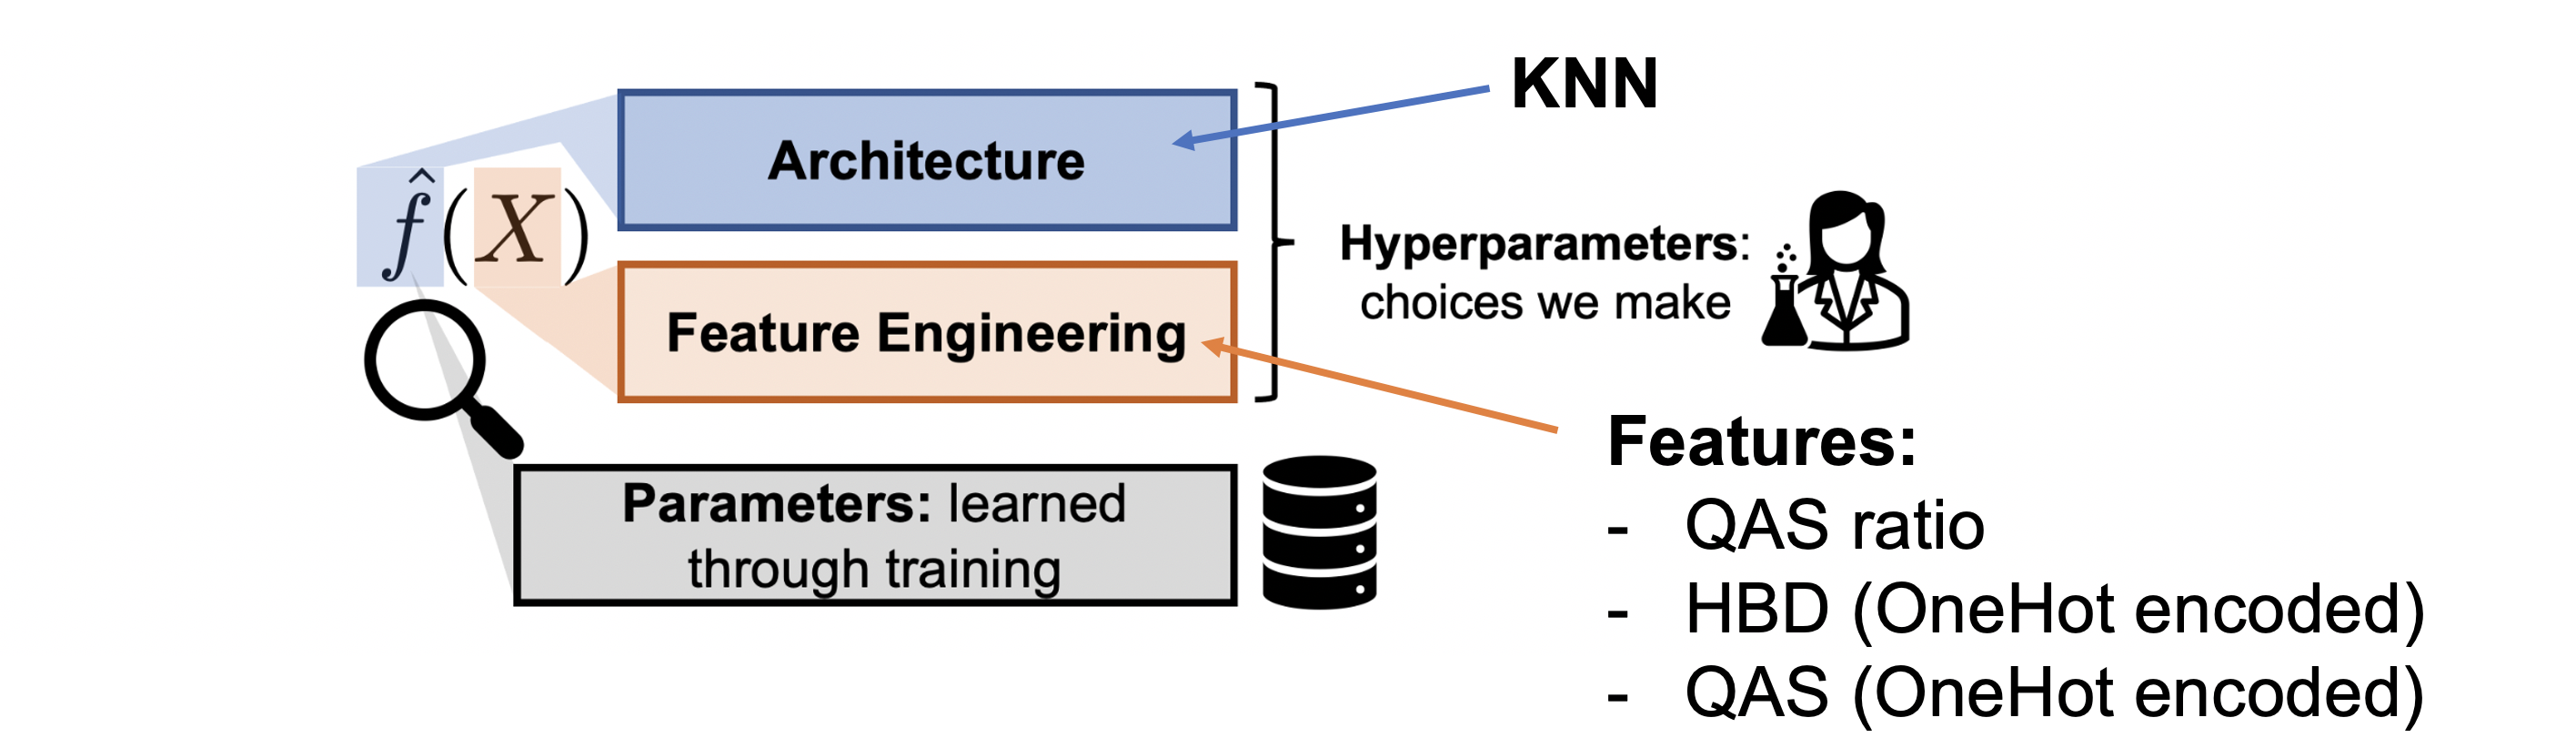

***

## 1. Does random splitting test my goal?


### A. _Exercise_: Where are the data points for a mixture?

<font size=4>In this exercise we will explore some of the __byproducts of randomly splitting out the test set__. I repeat the process below.

In [2]:
# load the data
df = pd.read_csv('../../datasets/Politi_DES/politi_des_reformatted.csv', index_col=0)

In [3]:
# drop unnecesary columns
df = df.drop(columns=['conductivity', 'cathodic_slope',
       'anodic_slope', 'cathodic_potential', 'anodic_potential',
       'potential_window'])

In [4]:
# split the data 
dev_data, test_data = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=777) # asking for 15% of the data to be test set

<font size=4>To be condusive for this exploration I concatenate the data back together with an indicator of which dataset the examples are from:

In [5]:
dev_data['set'] = 'dev'
test_data['set'] = 'test'
all_data = pd.concat([dev_data, test_data])

In [6]:
all_data.sample(5)

,QAS,HBD,QAS_xf,solid,set
520,Tetraethylammonium Iodide,"N,N-dimethylurea",0.4,True,dev
46,Choline Chloride,"N,N-dimethylurea",0.8,True,test
80,Choline Chloride,L-serine,0.6,True,dev
210,Acetylcholine Chloride,4-amino triazole,0.5,False,test
503,Tetraethylammonium Iodide,Glycerol,0.9,True,dev


<font size=4>__Choose a particular mixture of QAS and HBD__ and create a plot of whether the sample was solid as the QAS mol fraction increases. __Color the plot to indicate which data was in the test and which was in the training set.__ Repeat for other mixtures if you have time.

> <span style='color:red'>remove for lecture

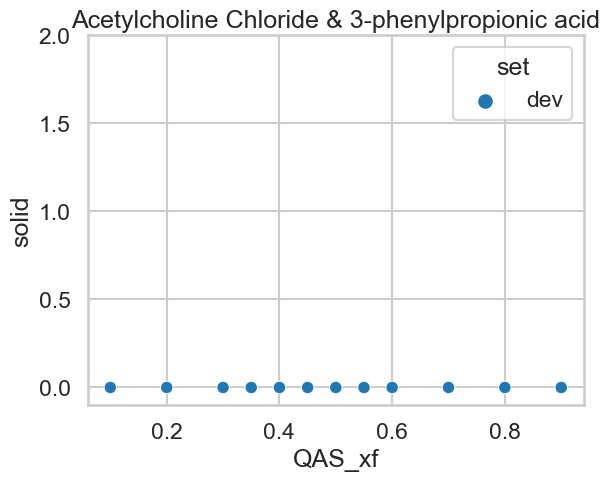

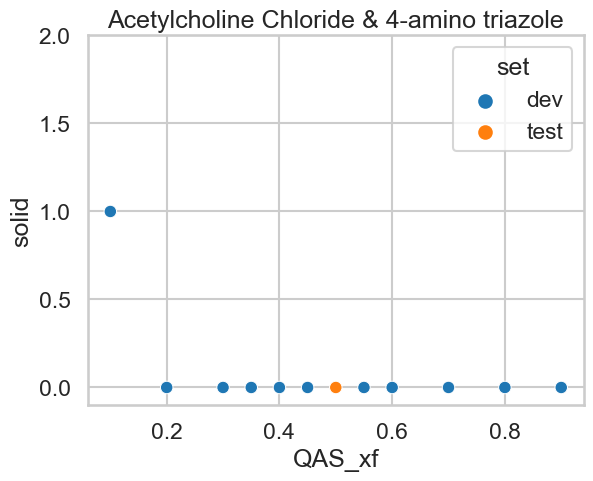

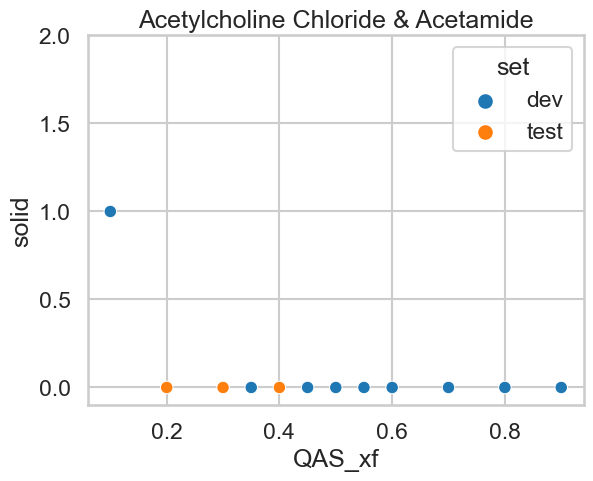

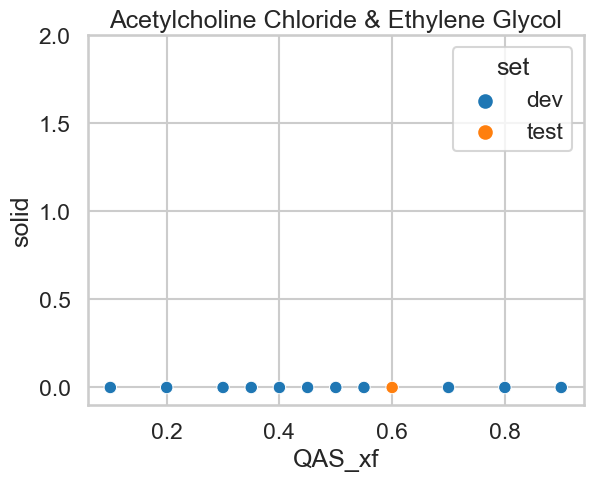

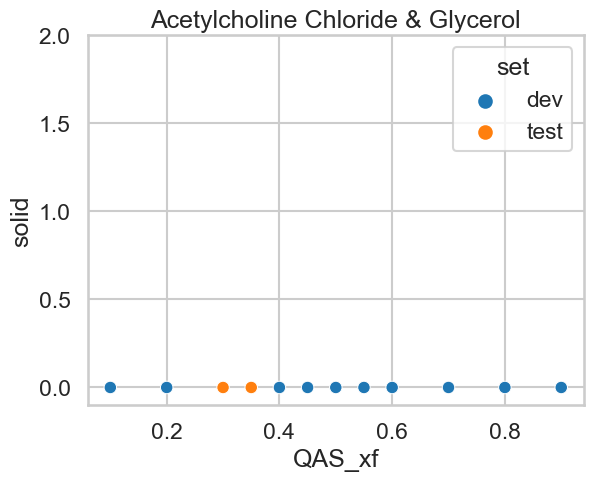

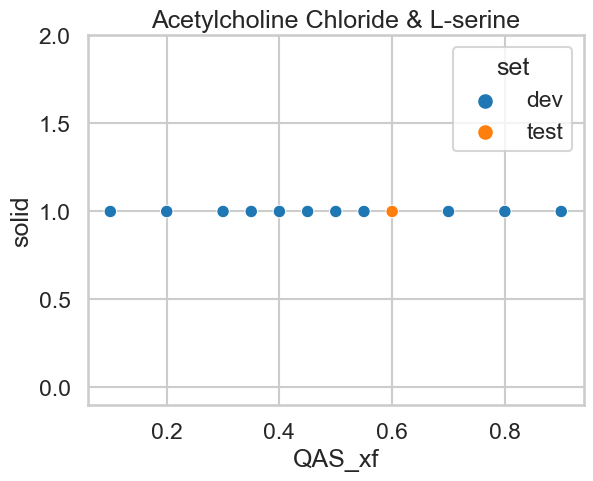

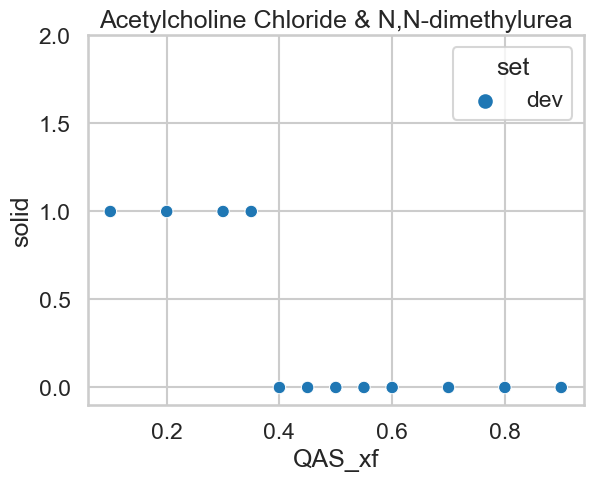

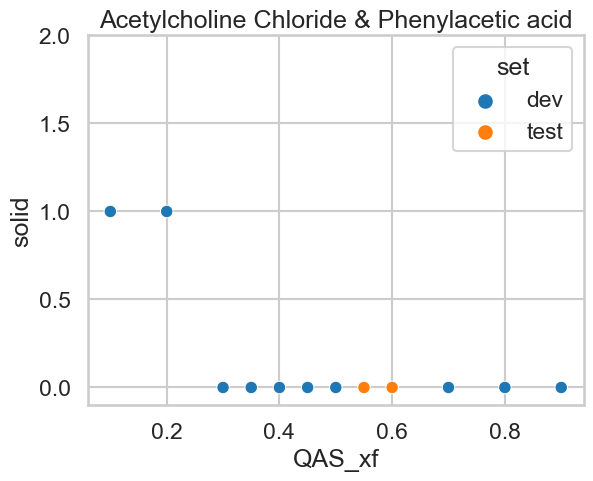

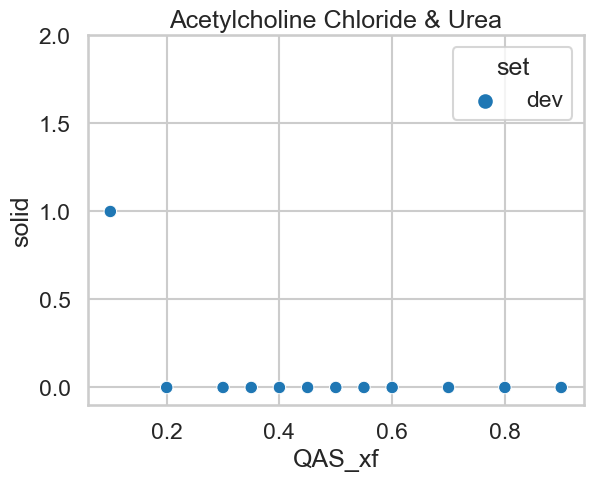

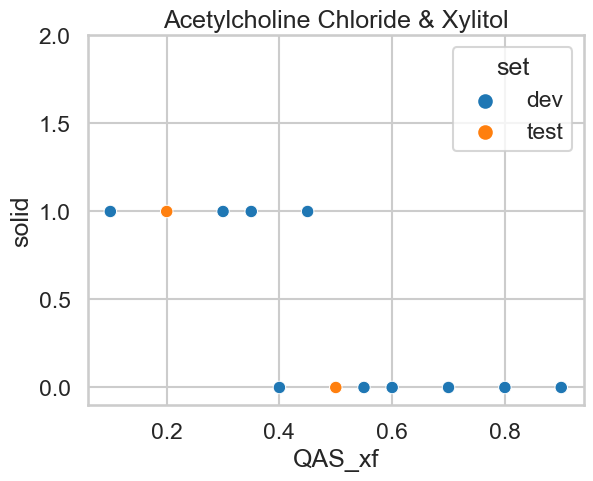

In [7]:
mixtures = all_data.groupby(['QAS', 'HBD'])
n_plotted = 0
for components, mixture_df in mixtures:
    fig, ax = plt.subplots()
    sns.scatterplot(mixture_df, x='QAS_xf', y='solid', hue='set', ax=ax)
    ax.set_title(' & '.join(components))
    ax.set_ylim((-.1,2))
    n_plotted += 1
    if n_plotted == 10:
        break

<font size=5><center>What is the primary goal here we are really testing, given these plots?

### B. New goal new split

<font size=5><center>Instead of making predictions for __new mixtures using compounds we have already used__ what if we modified our goal to be to predict __new mixtures using any QAS__?

<font size=4>We should reformat the dataset to be a better test than random split - the test set should contain at least one QAS never seen in training.

In [8]:
def dev_test_holdout_qas_compound(data: pd.DataFrame, test_qas_compound: str = 'Tetrapropylammonium Bromide'):
    test_mask = data['QAS'] == test_qas_compound
    return data[~test_mask], data[test_mask]

In [9]:
dev_data, test_data = dev_test_holdout_qas_compound(df)

<font size=4>Let's go ahead and preprocess this data, train, and test a KNN just like last time with this new data.

In [10]:
# same code as last NB
def seperate_nominal_features(dataframe, target_name, nominal_features=[]):
    # get y values
    y = dataframe[target_name].values.reshape(-1,1)
    
    # get all other columns
    quantitative_features = [c for c in dataframe.columns if c not in nominal_features and c != target_name]
    
    # return the data seperated
    return {
        'nominal_X': dataframe[nominal_features].values,
        'quantitative_X': dataframe[quantitative_features].values,
        'y': y
    }

In [11]:
# same code as last NB
dev_data = seperate_nominal_features(dev_data, target_name='solid', nominal_features=['QAS', 'HBD'])
test_data = seperate_nominal_features(test_data, target_name='solid', nominal_features=['QAS', 'HBD'])

In [12]:
# same code as last NB
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
encoder.fit(dev_data['nominal_X'])

OneHotEncoder(sparse=False)

In [13]:
# same code as last NB
# transform the data in both datasets
dev_data['nominal_X'] = encoder.transform(dev_data['nominal_X'])
test_data['nominal_X'] = encoder.transform(test_data['nominal_X'])

ValueError: Found unknown categories ['Tetrapropylammonium Bromide'] in column 0 during transform

<font size=5><center>Our encoding method is __no longer valid__!

<font size=4>The One-Hot encoder takes a nominal value and assigns it to an indicator, where the total possible number of indicators is the total possible number of nominal values. Given that we now have an infinite number of possible QAS, this doesn't jive.

<font size=4>Let's fib it just to explore this new problem, __in practice always fit encoders and preprocessing steps to the dev data__

In [14]:
dev_data, test_data = dev_test_holdout_qas_compound(df)
dev_data = seperate_nominal_features(dev_data, target_name='solid', nominal_features=['QAS', 'HBD'])
test_data = seperate_nominal_features(test_data, target_name='solid', nominal_features=['QAS', 'HBD'])

In [15]:
# fit encoder using all data instead of just dev
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
encoder.fit(np.concatenate([dev_data['nominal_X'], test_data['nominal_X']]))

OneHotEncoder(sparse=False)

In [16]:
# transform the data in both datasets
dev_data['nominal_X'] = encoder.transform(dev_data['nominal_X'])
test_data['nominal_X'] = encoder.transform(test_data['nominal_X'])

In [17]:
# concatenate the encoded nominal features and the quantitative features back together
# same code from last NB
dev_X = np.concatenate([dev_data['nominal_X'], dev_data['quantitative_X']], axis=1)
test_X = np.concatenate([test_data['nominal_X'], test_data['quantitative_X']], axis=1)

# asign y data to new variables
dev_y = dev_data['y']
test_y = test_data['y']

In [18]:
# standardize the data
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(dev_X)
dev_X = scaler.transform(dev_X)
test_X = scaler.transform(test_X)

### C. _Poll_: How will the new model perform

<font size=4>Given our new problem is to make predictions for __never seen before QAS__ and we have created a dataset to test this, will the model perform worse, about the same, or better?

### D. Feature distributions should overlap

<font size=4>Train and test this model

In [19]:
# train the model using the training data
model = sklearn.neighbors.KNeighborsClassifier()
model.fit(dev_X, dev_y) # pass X and y values

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [20]:
model.score(test_X, test_y)

0.625

<font size=4>It is about as good as a random guess.

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


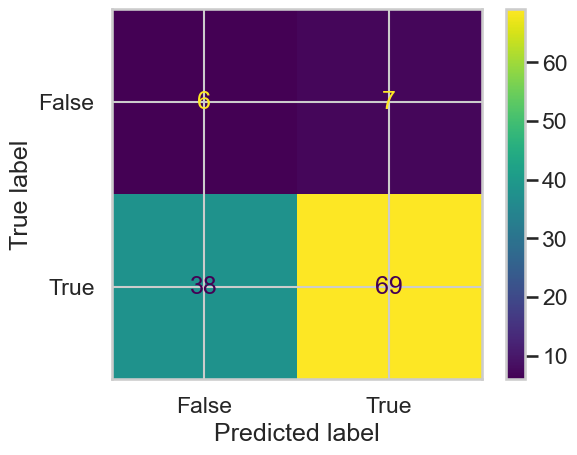

In [22]:
sklearn.metrics.plot_confusion_matrix(model, test_X, test_y)

<font size=4>This test dataset is very imbalanced - it is mostly solids. The model only manages to get 2/3 of those solids and it is about 50/50 on the liquids.

<font size=5><center>This failure can be traced back to one of the starting principles of testing the ML model: __the model has to be able to take what it knows from the training data and apply it to the testing data.__

<font size=4>Observe the distribution of features in the datasets:

In [23]:
feature_names = encoder.get_feature_names_out()
print(f"Encoded nominal feaures: {feature_names}")

Encoded nominal feaures: ['x0_Acetylcholine Chloride' 'x0_Choline Chloride'
 'x0_Tetraethylammonium Chloride' 'x0_Tetraethylammonium Iodide'
 'x0_Tetrapropylammonium Bromide' 'x1_3-phenylpropionic acid'
 'x1_4-amino triazole' 'x1_Acetamide' 'x1_Ethylene Glycol' 'x1_Glycerol'
 'x1_L-serine' 'x1_N,N-dimethylurea' 'x1_Phenylacetic acid' 'x1_Urea'
 'x1_Xylitol']


In [24]:
tpa_b_position_in_X = np.argwhere(feature_names=='x0_Tetrapropylammonium Bromide')[0][0]
print(f"If the QAS is TPA B, it is indicated in the {tpa_b_position_in_X}th column of the feature vector")

If the QAS is TPA B, it is indicated in the 4th column of the feature vector


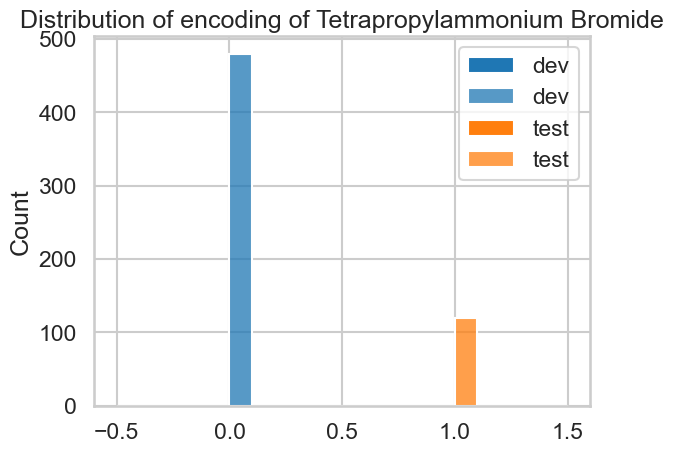

In [25]:
fig, ax = plt.subplots()
sns.histplot(x=dev_X[:,tpa_b_position_in_X], ax=ax, label='dev', bins=10)
sns.histplot(x=test_X[:,tpa_b_position_in_X], ax=ax, label='test', bins=10)
ax.set_title('Distribution of encoding of Tetrapropylammonium Bromide')
ax.legend()

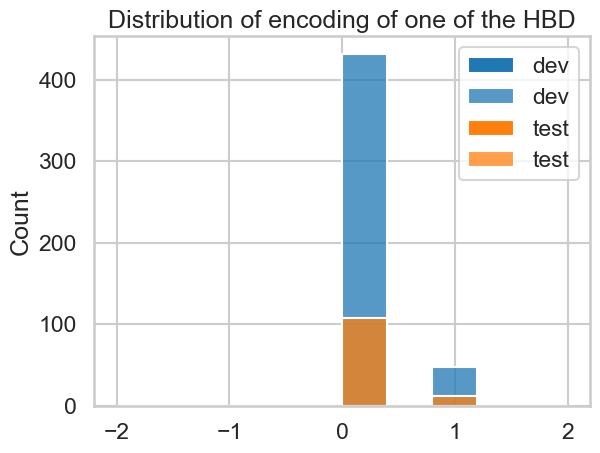

In [26]:
fig, ax = plt.subplots()
sns.histplot(x=dev_X[:,8], ax=ax, label='dev', binrange=(-2,2), bins=10)
sns.histplot(x=test_X[:,8], ax=ax, label='test', binrange=(-2,2), bins=10)
ax.set_title('Distribution of encoding of one of the HBD')
ax.legend()

<font size=5><center>We can see that because we split by QAS and we encoded QAS with one-hot, __the values of that feature in dev and test do not overlap at all.__

## 2. Feature Engineering

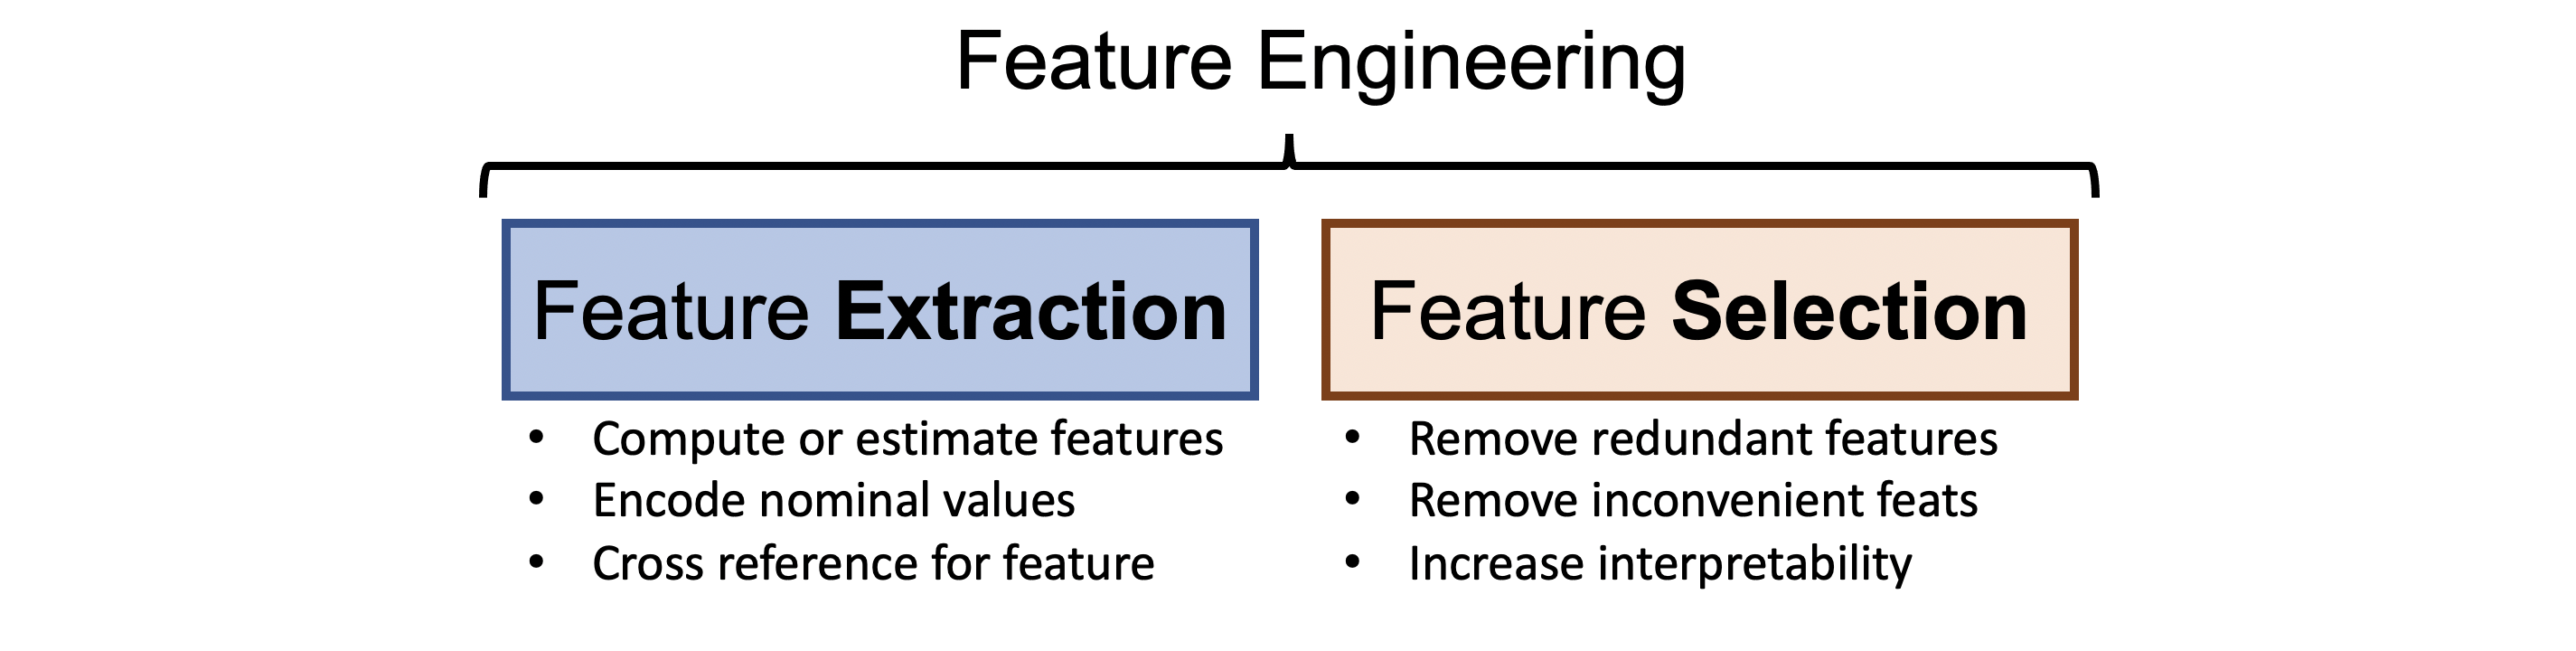

<font size=4>We did some high level selection last notebook when __we dropped the quantitative sample measurements because to use those features for new samples, we would have to make the sample__. Selection will be discussed more in a future NB.
    
<font size=4>Here, __let's do some extraction__ in order to address the problem with one-hot encoding that arose given our new SML goal.

### A. _Poll_: can we compute useful information?

<font size=4>Instead of indicating whether a structure is a particular structure, can we extract usefull information? If I give you a structure, what are some quantitities you could quickly provide or estimate?

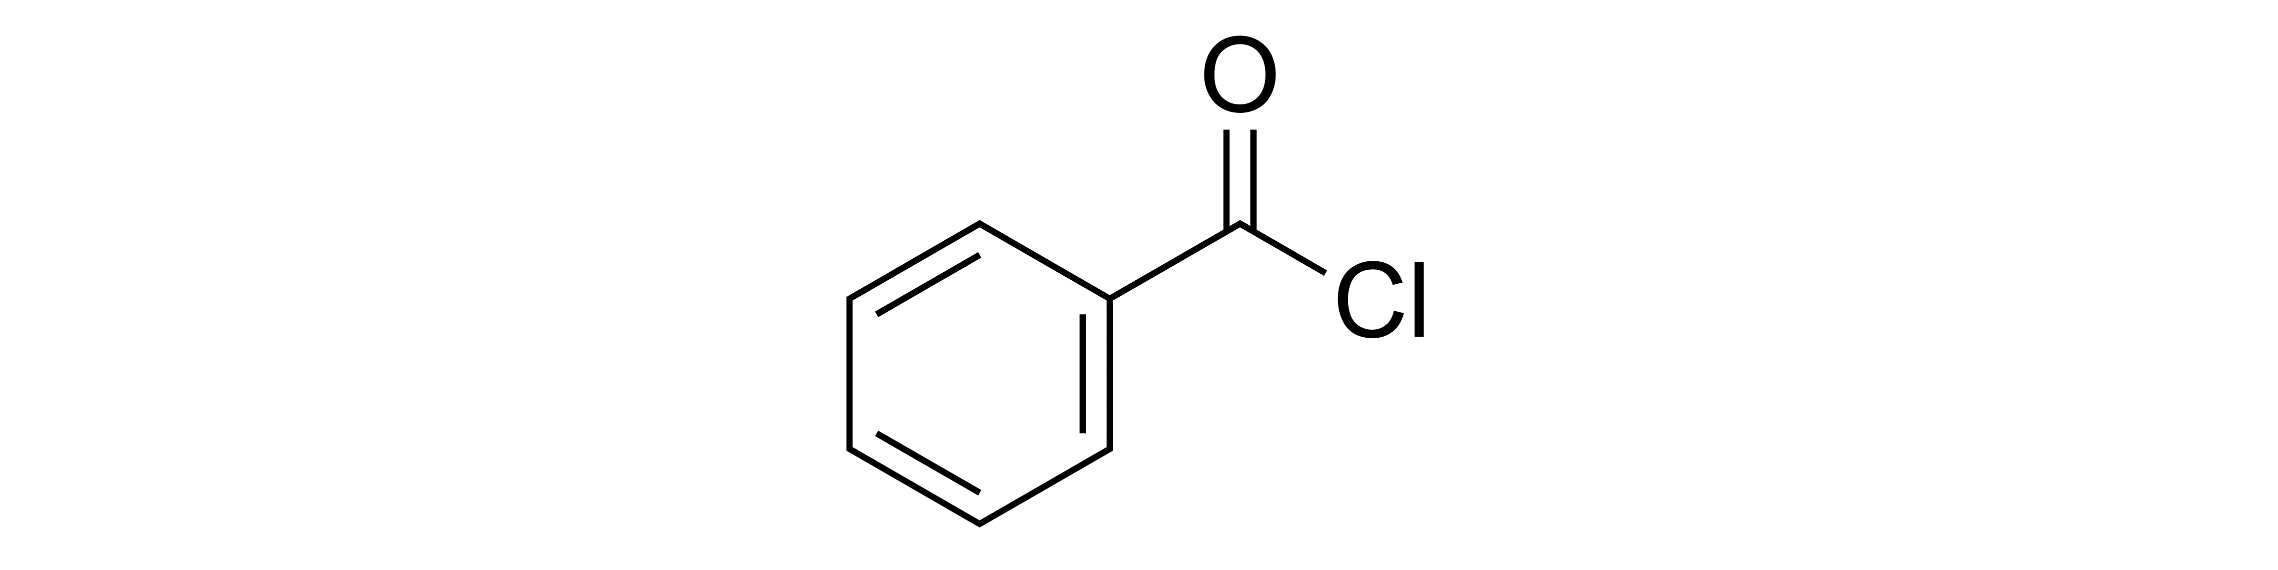

### B. Compute features for nominal data

<font size=5><center>What __about the QAS can we calculate__ that we expect will effect its performance in a DES?

- <font size=4>__Molar mass__: size of a molecule effects most molecules behavior fairly ubiquitously.
    
- <font size=4>__Melting point__: The melting point of the QAS and the HBD individually relates heavily with the melting point of the mixture

- <font size=4>__Halide__: The interaction of the QAS with the HBD is dominated by the halide
    
<font size=4>There are __many more__ that we could think of (and tools in python to get them automatically!) but for now let's start here. Here are those values for each QAS in arrays:

In [27]:
qas_features = {
    'Acetylcholine Chloride': [181.086956432, 150, 1], 
    'Choline Chloride': [139.076391748, 302, 1],
    'Tetraethylammonium Chloride': [165.12842732, 360, 1],
    'Tetraethylammonium Iodide': [257.06404764, 280, 3],
    'Tetrapropylammonium Bromide': [265.140511996, 286, 2]}

<font size=5><center>A model that encodes QAS with these features will no longer break for a new QAS because the __new QAS has a molar mass, halide, and a melting point, unlike One-hot where a new QAS would not have an associated indicator__.

In [28]:
dev_data, test_data = dev_test_holdout_qas_compound(df)

In [29]:
# encode HBD with one hot
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
encoder.fit(dev_data['HBD'].values.reshape(-1,1))

OneHotEncoder(sparse=False)

In [30]:
def get_Xy(dataframe, fit_encoder):
    # Encode HBD
    X_hbd = fit_encoder.transform(dataframe['HBD'].values.reshape(-1,1))
    
    # encode qas with features
    X_qas = np.array(
        [qas_features[qas] for qas in dataframe['QAS']]
    )
    # get the mole ratio, already a quantitative feature
    X_ratio = dataframe['QAS_xf'].values.reshape(-1,1)
    
    # concatenate along feature axis
    X = np.concatenate([X_hbd, X_qas, X_ratio], axis=1)
    
    return X, dataframe['solid'].values.reshape(-1,1)

In [31]:
dev_X, dev_y = get_Xy(dev_data, encoder)
test_X, test_y = get_Xy(test_data, encoder)

In [32]:
print(f"Shape of X, y data for the dev set: ", dev_X.shape, dev_y.shape)
print(f"Shape of X, y data for the test set: ", test_X.shape, test_y.shape)

Shape of X, y data for the dev set:  (480, 14) (480, 1)
Shape of X, y data for the test set:  (120, 14) (120, 1)


<font size=4>Still need to standardize

In [33]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(dev_X)

dev_X = scaler.transform(dev_X)
test_X = scaler.transform(test_X)

<font size=4>Let's confirm we have overlap

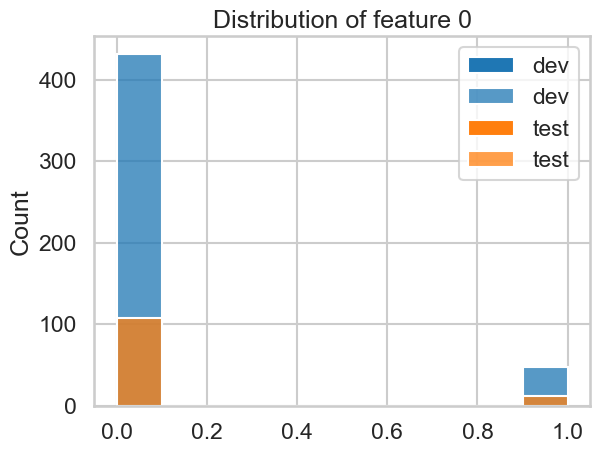

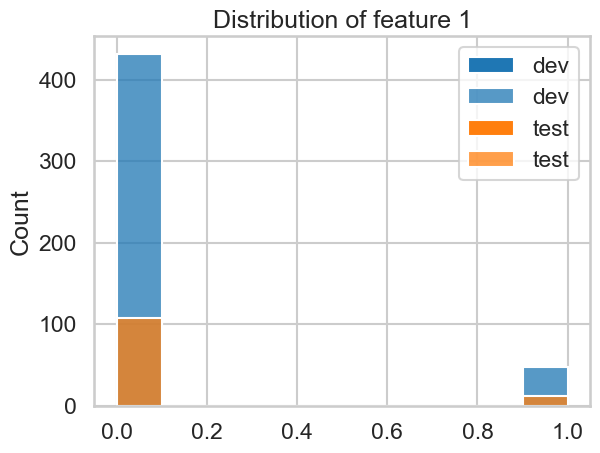

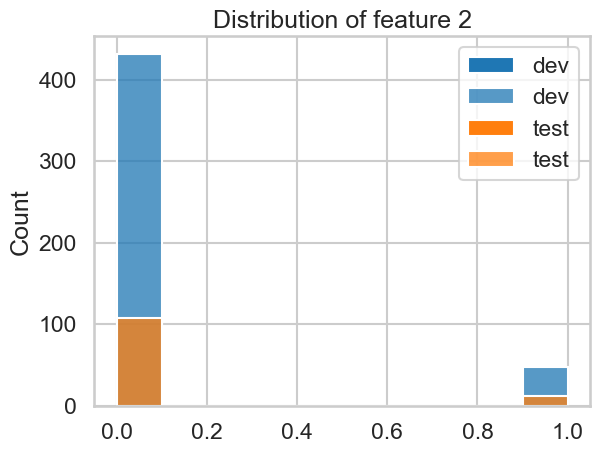

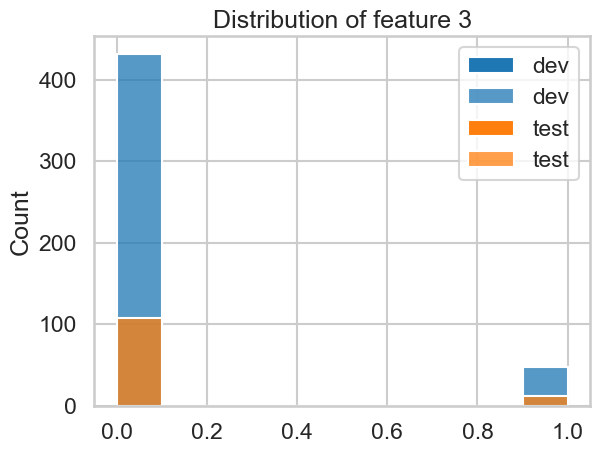

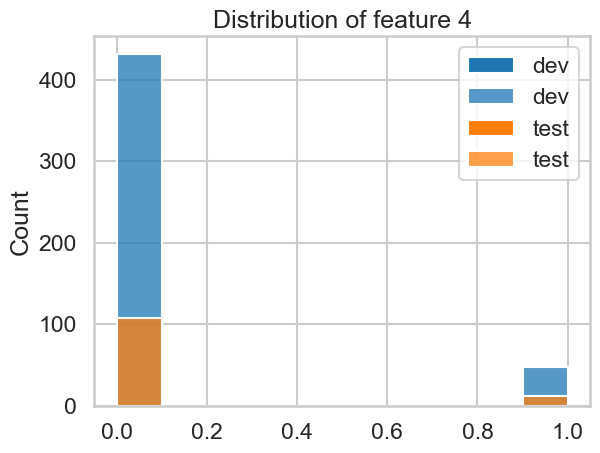

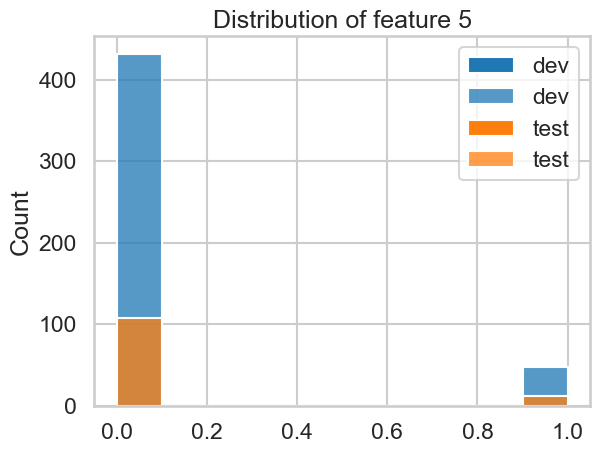

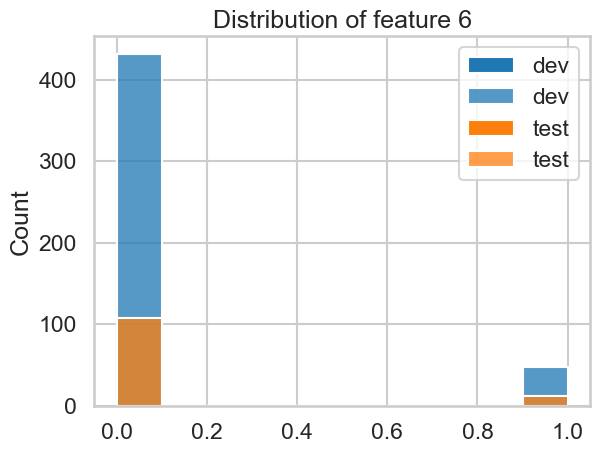

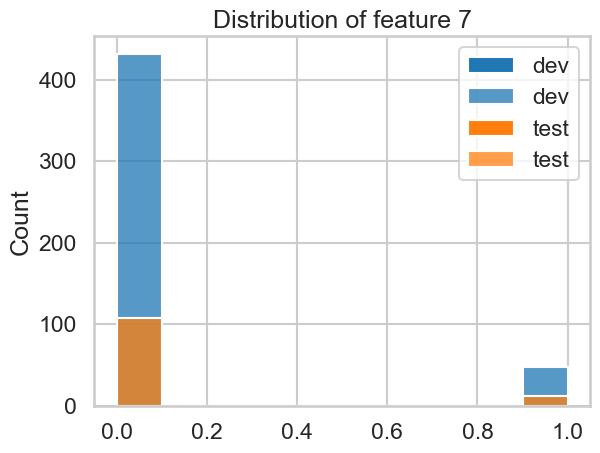

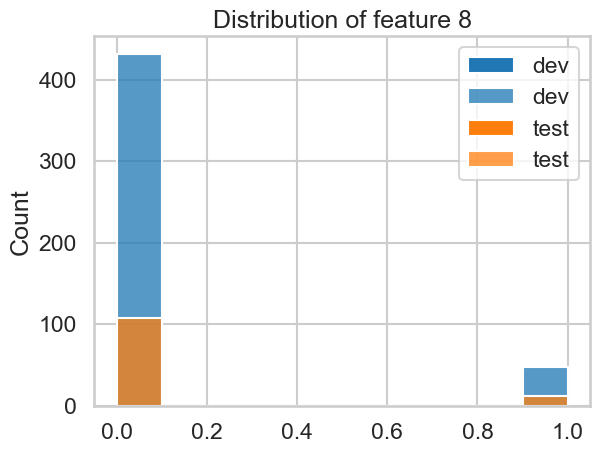

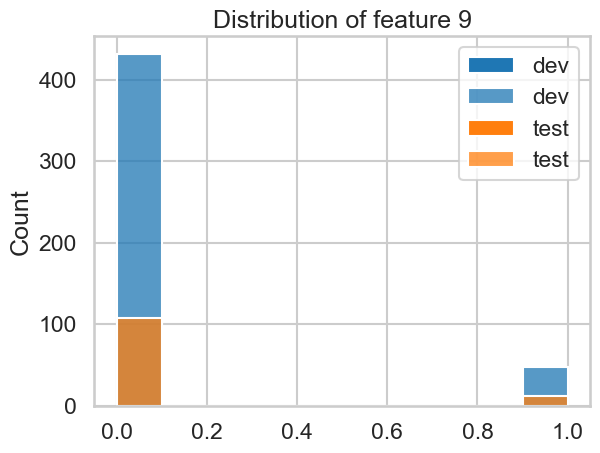

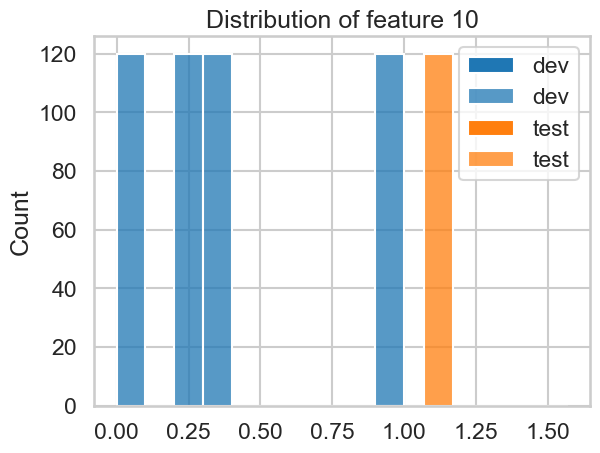

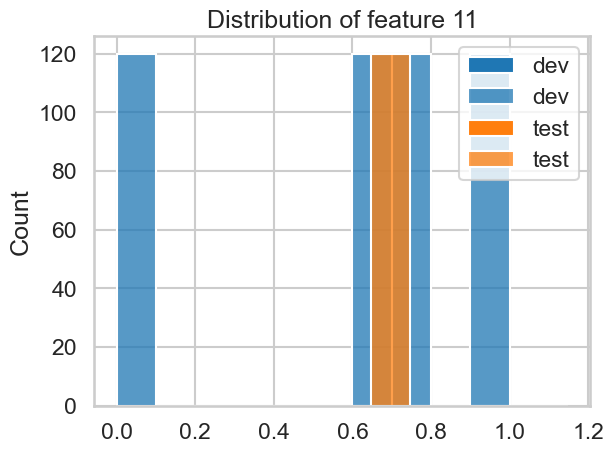

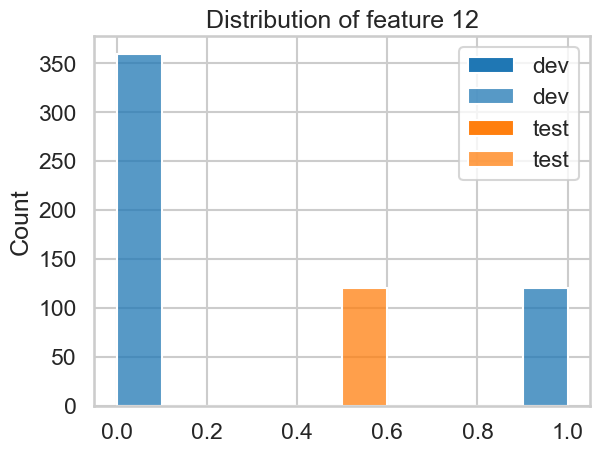

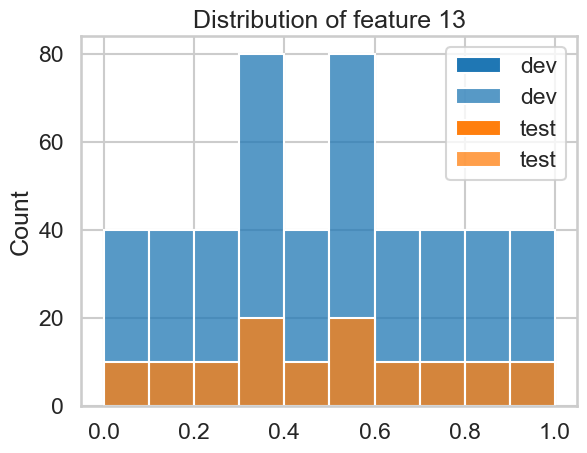

In [34]:
for i in range(dev_X.shape[1]):
    fig, ax = plt.subplots()
    sns.histplot(x=dev_X[:,i], ax=ax, label='dev', bins=10)
    sns.histplot(x=test_X[:,i], ax=ax, label='test', bins=10)
    ax.set_title(f'Distribution of feature {i}')
    ax.legend()

<font size=5><center>There is one feature out of range in the test set but it is very close to the maximum. __This problem is no longer contrived__ since we can determine these three quantities for any new QAS, __the model can leverage what it has learned in training!__
    
*Note that if a new QAS has a Molar mass or melting point far out of range, or a halide that is bigger than iodine, it would not be a good test. __But at least it would not break__.* 

In [35]:
# train the model using the training data
model = sklearn.neighbors.KNeighborsClassifier()
model.fit(dev_X, dev_y) # pass X and y values

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [36]:
model.score(test_X, test_y)

0.8916666666666667

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


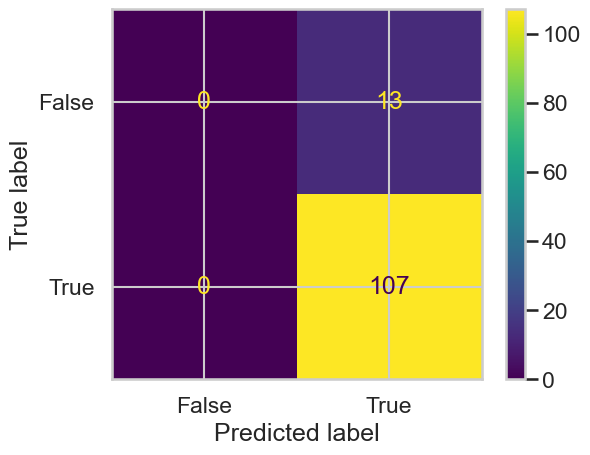

In [37]:
sklearn.metrics.plot_confusion_matrix(model, test_X, test_y)

<font size=4>The model is able to capture __all__ of the solids, but it also fails the get the small number of liquids.

### C. _Exercise_: cross validation

<font size=4>To test the goal "can we predict if a sample will be solid for any future QAS" we ditched random splitting, which a test more of interpolation, and created a new one with a single QAS reserved. While this is theoretically a better test, __it is not very statistically sound because we only tested one QAS__!
    
<font size=4>Repeat what we did above: split the data, encode it, scale it, train and test, __for each possible QAS__ being held out. Average the score over these to estimate how well this strategy actually meets the goal.

> <span style='color:red'>remove for lecture

In [40]:
def split_train_test_one(test_qas_compound):
    # split by the QAS
    dev_data, test_data = dev_test_holdout_qas_compound(df, test_qas_compound=test_qas_compound)
    
    # fit encoder for HBD
    encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
    encoder.fit(dev_data['HBD'].values.reshape(-1,1))
    
    # get features and y
    dev_X, dev_y = get_Xy(dev_data, encoder)
    test_X, test_y = get_Xy(test_data, encoder)
    
    # scale X data
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(dev_X)

    dev_X = scaler.transform(dev_X)
    test_X = scaler.transform(test_X)
    
    # train the model using the training data
    model = sklearn.neighbors.KNeighborsClassifier()
    model.fit(dev_X, dev_y) # pass X and y values
    
    return model.score(test_X, test_y)

In [41]:
scores = {}
for qas in df['QAS'].unique():
    scores[qas] = split_train_test_one(qas)

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/DSMCER_general_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarnin

In [42]:
scores

{'Choline Chloride': 0.6916666666666667,
 'Acetylcholine Chloride': 0.2916666666666667,
 'Tetraethylammonium Chloride': 0.6666666666666666,
 'Tetrapropylammonium Bromide': 0.8916666666666667,
 'Tetraethylammonium Iodide': 0.9}

In [44]:
np.mean(list(scores.values()))

0.6883333333333332

In [45]:
np.std(list(scores.values()))

0.22089464557667404

<font size=4>We can expect to be better than random guess most of the time!

## Summary

- <font size=4>We showed that __the test set you create need to include new data in a way that best tests your goal for the model__. A test of interpolation would look different than a test of new compounds
    
- <font size=4>__We can extract features for data__ (in this case chemical compounds) such that even a test set that has new types of examples still overlaps with the training data features.
    
- <font size=4>__We can average over different test sets to get a more reliable estimation of quality with cross validation.__